In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
from libs.activations import lrelu
from libs.utils import corrupt


# %%
def autoencoder(input_shape=[None, 64,64,3],
                n_filters=[1, 32, 64, 64],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):

    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')


    # %%
    # ensure 2-d is converted to square tensor.
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x.get_shape()) == 4:
        x_tensor = x
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Optionally apply denoising autoencoder
    if corruption:
        current_input = corrupt(current_input)

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%

        # %% Build the encoder
    encoder_inter = []
    # print current_input.get_shape().as_list()
    all_num_feat=current_input.get_shape().as_list()[3]*current_input.get_shape().as_list()[1]*current_input.get_shape().as_list()[2]
    # print 'feat num is ',all_num_feat



    current_input=tf.reshape(current_input,[-1,all_num_feat])
    for layer_i, n_output in enumerate([4096,1024,4096]):
        n_input = int(current_input.get_shape()[1])
        W = tf.Variable(
            tf.random_uniform([n_input, n_output],
                              -1.0 / math.sqrt(n_input),
                              1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder_inter.append(W)
        output = lrelu(tf.matmul(current_input, W) + b)
        current_input = output

        if layer_i==1:
            feat=output

    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()



    current_input=tf.reshape(current_input,[-1,8,8,64])
    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output


    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.sqrt(tf.reduce_sum(tf.square(y - x_tensor)))/784

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost,'feat':feat}


# %%

import random
from skimage.io import imread
from skimage.transform import resize
def get_random_array(all_list,batch_size=50,weights=None):
    random.shuffle(all_list)
    all_list=all_list[:batch_size]
    IM_SIZE=64
    data_array=np.ndarray((batch_size,IM_SIZE,IM_SIZE,3))
    label_vec=np.ndarray((batch_size))
    for i,t in enumerate(all_list):
        fpath,label=t[:-1].split(' ')
        prepath='/media/wei/DATA/CIFEv2.0/'
        im_i=imread(prepath+fpath)
        im_i=im_i[...,::-1]
        im_i=resize(im_i,(IM_SIZE,IM_SIZE))
        if len(im_i.shape)==2:
            for j in range(3): data_array[i,:,:,j]=im_i 
        else:
            data_array[i,...]=im_i
        label_vec[i]=float(label)
    return data_array,label_vec

['webemo_tr/D005964.jpg 3\n', 'webemo_tr/A001525.jpg 0\n', 'webemo_tr/F008089.jpg 5\n']
(0, 0.43151826)
(1, 0.25450608)
(2, 0.23010705)
(3, 0.18844263)
(4, 0.17972404)
(5, 0.16865624)
(6, 0.16382942)
(7, 0.1385753)
(8, 0.14710914)
(9, 0.13812728)
(10, 0.12687163)
(11, 0.13406293)
(12, 0.12822834)
(13, 0.11343734)
(14, 0.11986527)
(15, 0.11642858)
(16, 0.1038816)
(17, 0.10297868)
(18, 0.10475753)
(19, 0.10631934)
(20, 0.10470254)


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(21, 0.095973559)
(22, 0.098494656)
(23, 0.10981675)
(24, 0.099890888)
(25, 0.090728506)
(26, 0.091598451)
(27, 0.089007214)
(28, 0.093167365)
(29, 0.090771921)
(30, 0.093854234)
(31, 0.086756326)
(32, 0.085540481)
(33, 0.088372543)
(34, 0.089072175)
(35, 0.086799264)
(36, 0.084771052)
(37, 0.083868206)
(38, 0.088131808)
(39, 0.08221031)
(40, 0.084475383)
(41, 0.087101333)
(42, 0.084514089)
(43, 0.083357811)
(44, 0.083191119)
(45, 0.078962073)
(46, 0.082129166)
(47, 0.07877735)
(48, 0.07771901)
(49, 0.076017238)


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


NotImplementedError: 

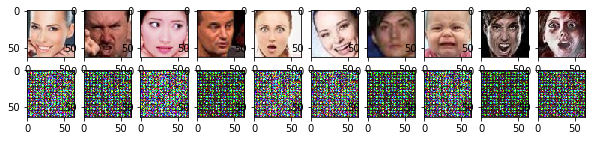

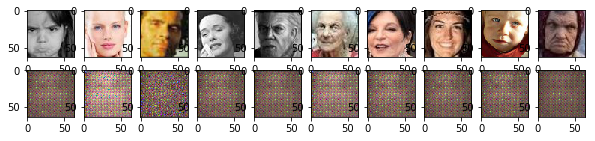

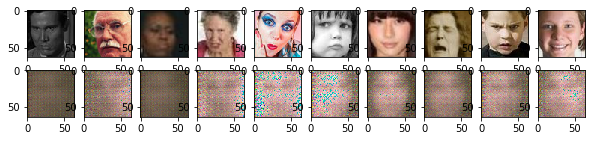

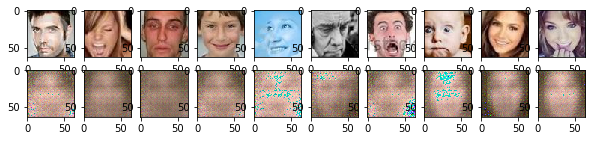

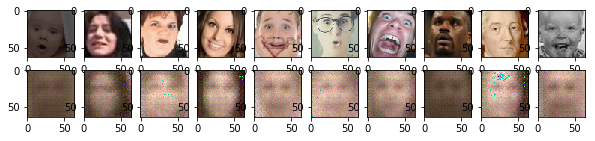

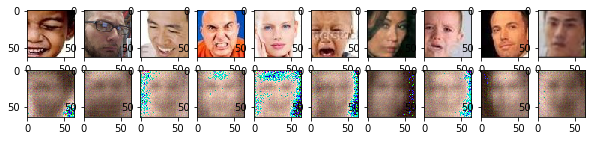

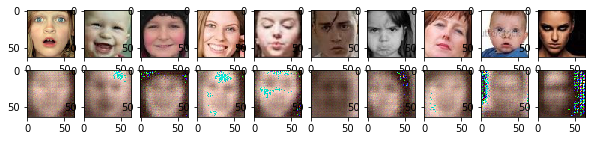

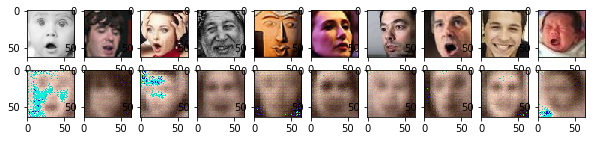

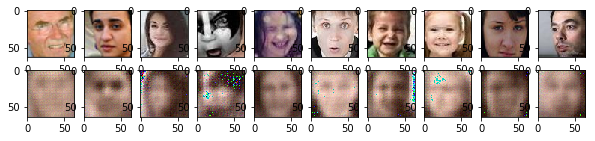

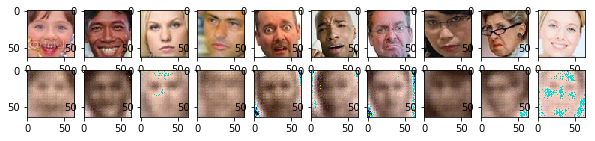

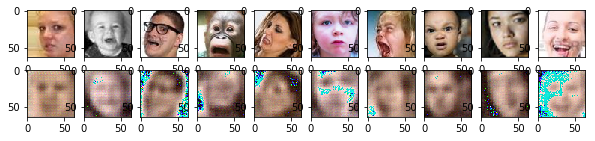

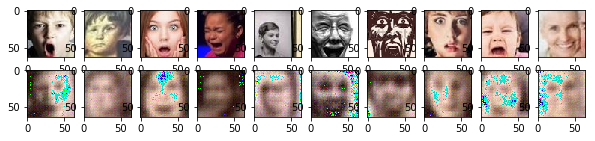

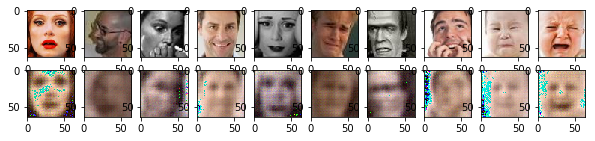

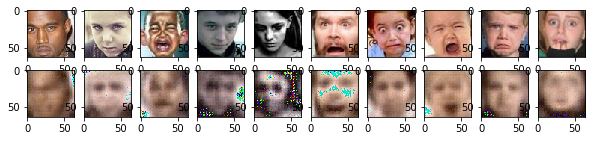

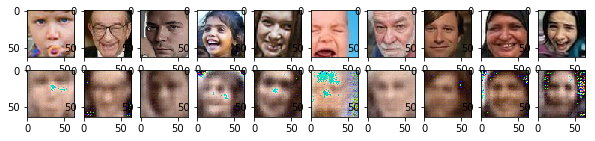

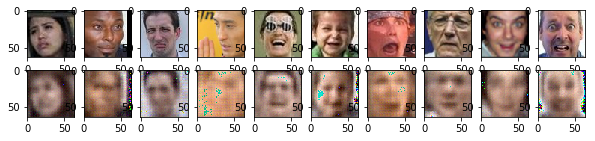

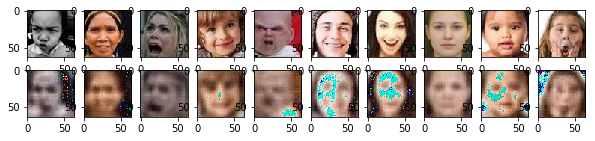

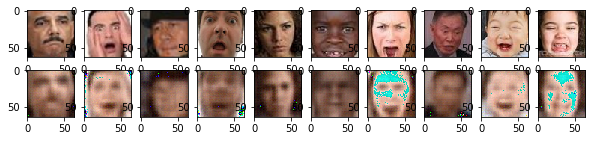

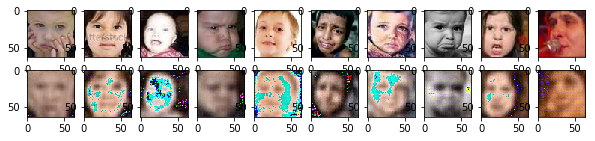

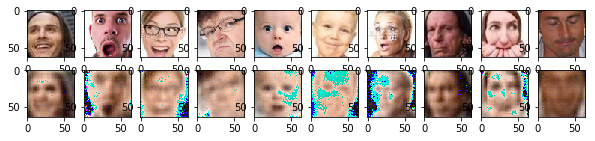

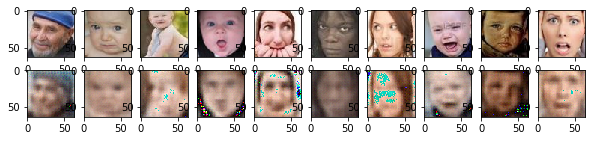

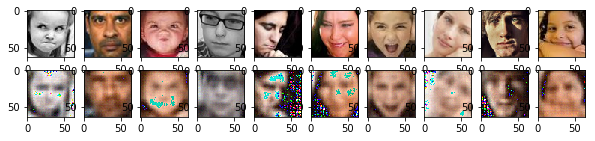

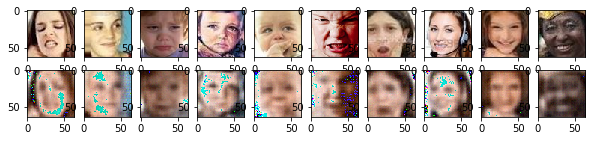

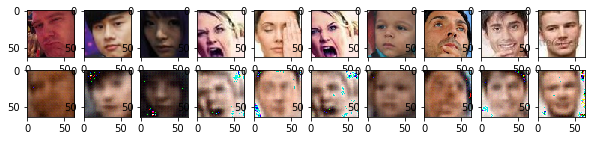

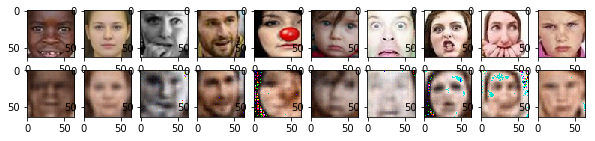

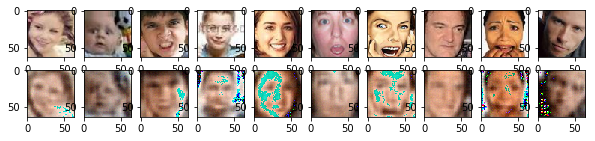

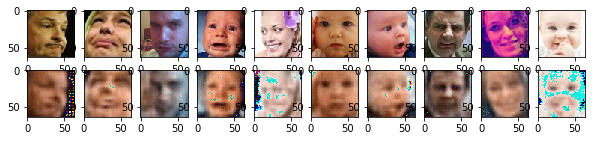

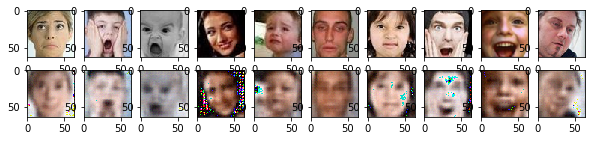

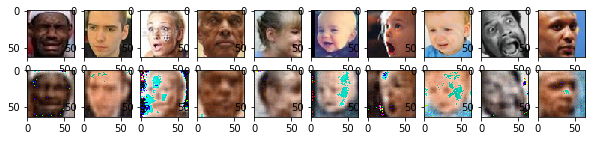

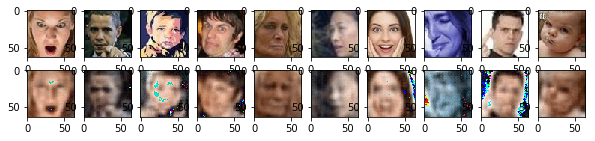

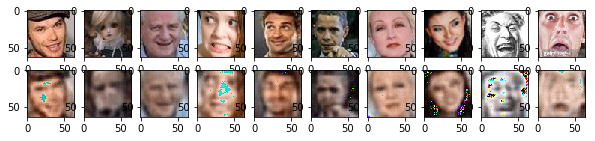

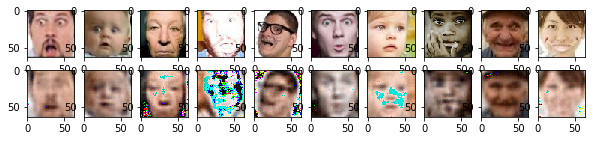

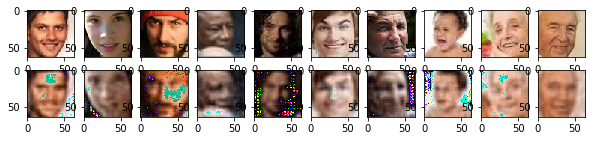

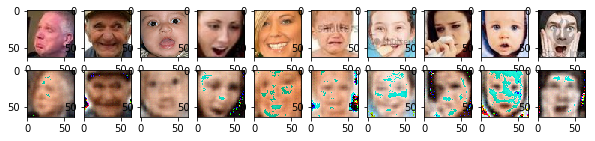

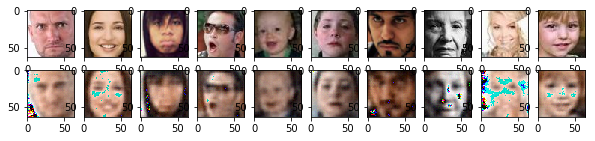

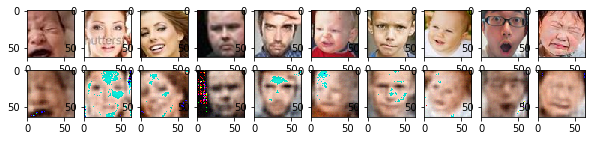

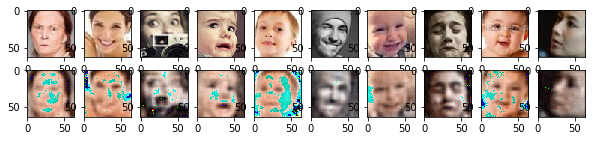

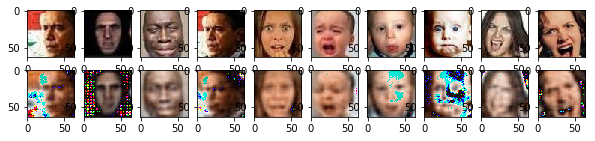

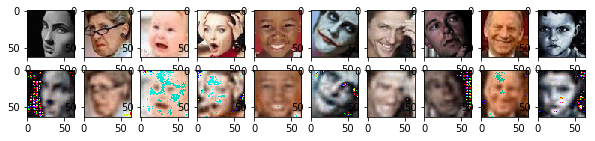

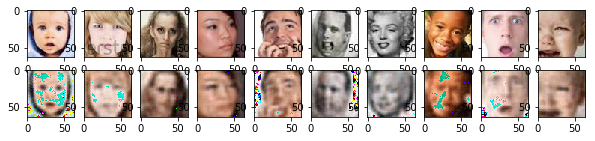

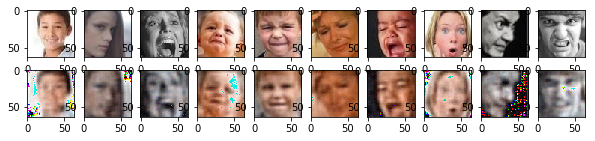

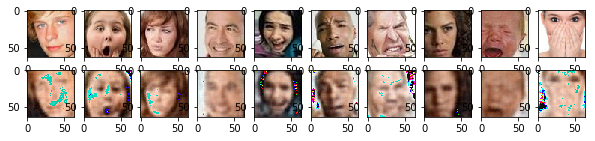

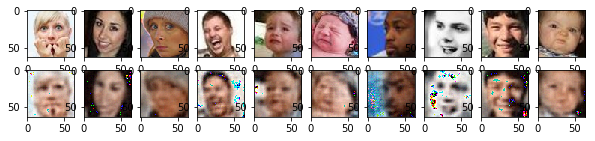

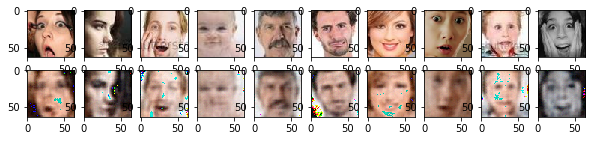

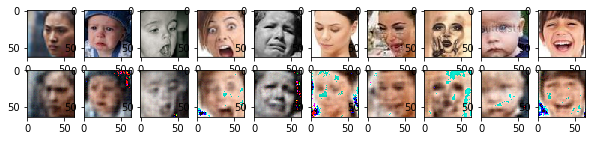

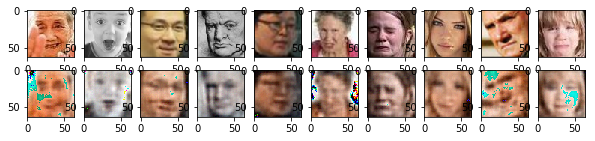

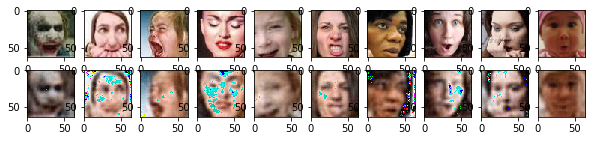

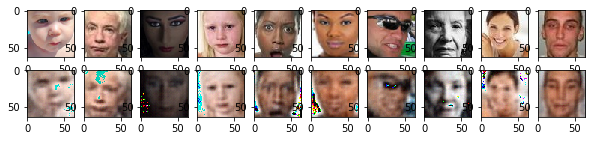

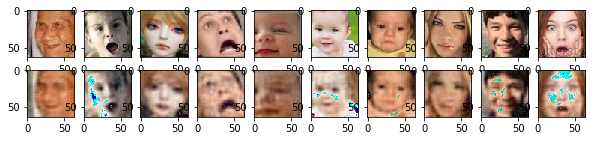

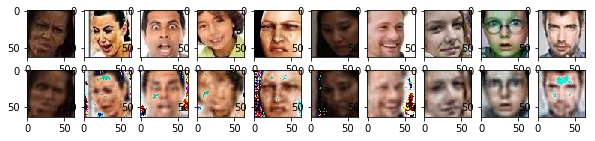

In [2]:
def run_experiment():
    """Test the convolutional autoencder using MNIST."""
    #indicating how to load data in tensorflow for training
    
    # %%
    import tensorflow as tf
    import tensorflow.examples.tutorials.mnist.input_data as input_data
    import matplotlib.pyplot as plt

    #read data from cife
    filename='train_fvgg_emo.txt'
    
    fp1=open(filename,'r')
    l1=fp1.readlines()
    
    print l1[:3]
    
    filename='test_fvgg_emo.txt'
    fp2=open(filename,'r')
    l2=fp2.readlines()
    
    
    
    ae = autoencoder()

    # %%
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # new_saver = tf.train.import_meta_graph('auto_encoder.meta')
    # new_saver.restore(sess, 'auto_encoder.data-00000-of-00001')

    # %%
    # Fit all training data
    batch_size = 100
    n_epochs = 50
    for epoch_i in range(n_epochs):
        for batch_i in range(50):

            train_array,train_lb=get_random_array(l1)
            sess.run(optimizer, feed_dict={ae['x']:train_array})
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train_array}))
        # print(epoch_i, sess.run(ae['feat'], feed_dict={ae['x']: train_array})) #use this as feature extraction
        n_examples = 10

        test_arr,test_lb=get_random_array(l2)


        recon = sess.run(ae['y'], feed_dict={ae['x']: test_arr})
        # print(recon.shape)
        fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
        for example_i in range(n_examples):
            axs[0][example_i].imshow(test_arr[example_i, ...][...,::-1])
            axs[1][example_i].imshow(recon[example_i, ...][...,::-1])

    saver=tf.train.Saver()
#     saver.save(sess, 'auto_encoder')
    fig.show()
    plt.draw()
    plt.waitforbuttonpress()


# %%
if __name__ == '__main__':
    run_experiment()